# MODELIZACIÓN DE LOS DATASETS DENOMINADOS CON 'SEL'

En el presente notebook se va a realizar la modelización de los siguientes conjuntos de datos:

- X_train_sel_und
- X_val_sel
- y_train_sel_und
- y_val_sel

Se trata de los **datasets obtenidos de las variables que la regularizaciones de Lasso y Ridge seleccionaban** (los datasets con 'sel') con el **undersampling realizado** en el anterior notebook **sobre el train**. En el siguiente notebook se realizará este mismo procedimiento con los datasets obtenidos tras la selección de variables y la feature ingeneering realizadas previamente (los datasets de 'red').

En primer lugar se construirá el modelo base (en concreto con imputación a la clase mayoritaria) aplicando sobre dicho modelo distintas métricas para comprobar su rendimiento. Con posterioridad se emplearán otros modelos vistos a lo largo de la asignatura para comprobar cuál es el mejor algoritmo para resolver el problema objeto de este proyecto, en base a **métricas como F1 score**. Estos modelos son:

- Modelo base con imputación a la clase mayoritaria
- Árbol de decisión
- Bayes
- Support Vector Machine
- Random Forest
- BaggingClassifier
- XGBoost
- AdaBoosting
- LightGBM

Una vez se concluya cuáles son los algoritmos candidatos a ganadores para este proyecto (después de los notebooks 6 y 7)  se procederá en el siguiente notebook a la optimización de parámetros y la evaluación del modelo con una serie de métricas (notebook 8).

Cabe destacar que se va a emplear la librería "time" para que quede reflejado el tiempo de ejecución de cada uno de los modelos analizados puesto que además de los resultados obtenidos es relevante contemplar el coste computacional y tiempo que dichos algoritmos requieren.


En primer lugar, se importan las librerías necesarias y se cargan los datos guardados en los notebooks previos (tanto de train como test) para emplearlos en los modelos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scikitplot as skplt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import ConfusionMatrixDisplay
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from tqdm import tqdm

In [ ]:
#pip install tqdm

In [3]:
#pip install scikit-plot

In [2]:
warnings.filterwarnings('ignore')

In [5]:
X_train_sel_und = pd.read_csv("data/X_train_sel_und.csv")
X_val_sel = pd.read_csv("data/X_val_sel.csv")
y_train_sel_und = pd.read_csv("data/y_train_sel_und.csv")
y_val_sel = pd.read_csv("data/y_val_sel.csv")

Se elimina de los distintos archivos la columna "Unnamed: 0" puesto que se genera automáticamente al guardar los documentos csv pero no es de interés en este trabajo.

In [6]:
X_train_sel_und = X_train_sel_und.drop(columns=["Unnamed: 0"])
X_val_sel = X_val_sel.drop(columns=["Unnamed: 0"])
y_train_sel_und = y_train_sel_und.drop(columns=["Unnamed: 0"])
y_val_sel = y_val_sel.drop(columns=["Unnamed: 0"])

# MODELO BASE

Un modelo base es un modelo simple que se utiliza como punto de referencia para evaluar el rendimiento de modelos más avanzados. Sirve como una referencia básica para determinar si los modelos complejos ofrecen mejoras significativas en el rendimiento. La elección de un modelo base proporciona un estándar mínimo que otros modelos deben superar para justificar su complejidad adicional.

En concreto, en este trabajo se ha optado para la construcción de un modelo base que impute a la clase mayoritaria, es decir, que predice la clase más frecuente en un conjunto de datos desbalanceado. Además, se establece una semilla para la generación de números aleatorios de 12345 para garantizar que el comportamiento sea reproducible y si se ejecuta el código varias veces con esta semilla se obtengan los mismos resultados.

Señalar que al no tratarse de un algoritmo de regresión (DummyClassifier) se emplean los datasets no estandarizados.

En primer lugar se define la función 'evaluate_model', que toma tres parámetros y muestra las siguientes métricas:

- Puntuación ROC-AUC: Esto se imprime solo si se proporciona ypred_proba. Evalúa el área bajo la curva de Característica Operativa del Receptor, lo cual es útil para problemas de clasificación binaria.

- Precisión (Accuracy): Calcula e imprime la precisión del modelo utilizando las etiquetas reales (ytest) y las etiquetas predichas (ypred).

- Informe de clasificación: Imprime el informe de clasificación, que incluye precisión, exhaustividad, puntuación F1 y soporte para cada clase.

In [7]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

A continuación, se emplea el 'DummyClassifier' con el objetivo de predecir siempre la clase más frecuente ('most_frequent') y una semilla (usando 'random_state=12345'). Posteriormente se crea un pipeline para este clasificador 'classifier':

In [8]:
classifier = DummyClassifier(strategy = 'most_frequent', random_state = 12345)

In [9]:
dummy_model = Pipeline(steps=[
    ('classifier',  classifier)
])

La siguiente línea de código está ajustando el modelo base o dummy utilizando el conjunto de datos de validación ('X_val_sel' e 'y_val_sel'), lo que significa que el modelo está siendo entrenado para hacer predicciones en base a la estrategia de clasificación más frecuente en este conjunto de datos de validación.

In [10]:
dummy_model.fit(X_val_sel,y_val_sel)

Pipeline(steps=[('classifier',
                 DummyClassifier(random_state=12345,
                                 strategy='most_frequent'))])

A continuación, por un lado 'pred' almacena las predicciones de la variable objetivo del conjunto de validación ('y_val_sel') realizadas en el conjunto de datos de validación ('X_val_sel'). Por otro lado, 'pred_proba' almacena las predicciones de las probabilidades de la variable objetivo del conjunto de validación ('y_val_sel') realizadas en el conjunto de datos de validación ('X_val_sel'):

In [11]:
pred = dummy_model.predict(X_val_sel)

pred_proba = dummy_model.predict_proba(X_val_sel)

Se va a evaluar el rendimiento del modelo base para 'y_val_sel', 'pred' :

In [12]:
evaluate_model(y_val_sel, pred)

Accuracy of the model: 0.98896875

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    158235
           1       0.00      0.00      0.00      1765

    accuracy                           0.99    160000
   macro avg       0.49      0.50      0.50    160000
weighted avg       0.98      0.99      0.98    160000




Se observa que el accuracy es de un 99%; sin embargo, mientras que la precisión cuando la variable objetivo toma valor 0 es de un 99% cuando toma valor 1 es de 0% (al igual que las métricas de recall y f1-score). Por tanto, el modelo base no va a ser el mejor modelo para el problema a estudiar en este proyecto y es necesario probar otros algoritmos más complejos.

A continuación vamos a evaluar el modelo base a través de otras métricas como son la matriz de confusión, la curva Roc, la curva Lift y la curva de Ganancias:

Confusion matrix, without normalization
[[158235      0]
 [  1765      0]]


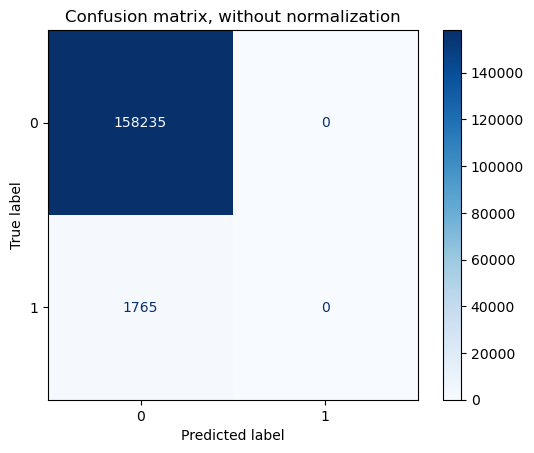

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


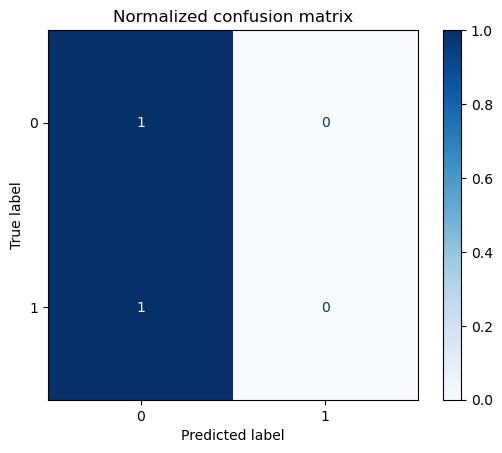

In [13]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dummy_model, X_val_sel, y_val_sel, 
        display_labels=dummy_model.classes_, 
        cmap=plt.cm.Blues, 
        normalize=normalize
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

En las matrices de confusión superiores se observa que el modelo base de imputación a la clase mayoritaria empleado proporciona tanto verdaderos positivos como falsos negativos (158235 y 1765, respectivamente sin normalizar).

A continuación se muestra una curva ROC que representa la capacidad del modelo base para clasificar la clase positiva frente a la clase negativa en diferentes umbrales de probabilidad. La línea punteada representa un clasificador sin habilidad discriminativa (No Skill), y la curva ROC del modelo dummy se traza en la gráfica:

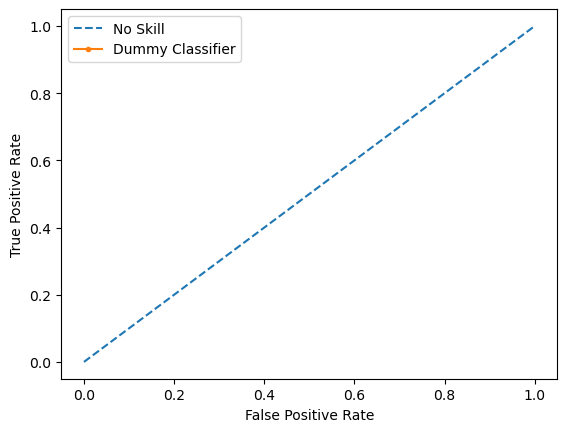

In [14]:
yhat = pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_val_sel, yhat, pos_label='1')

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Dummy Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

Se observa que la curva ROC ni aparece

A continuación, se muestran la curvas Lift y de Ganancias con 'y_val_sel' e 'pred_proba':

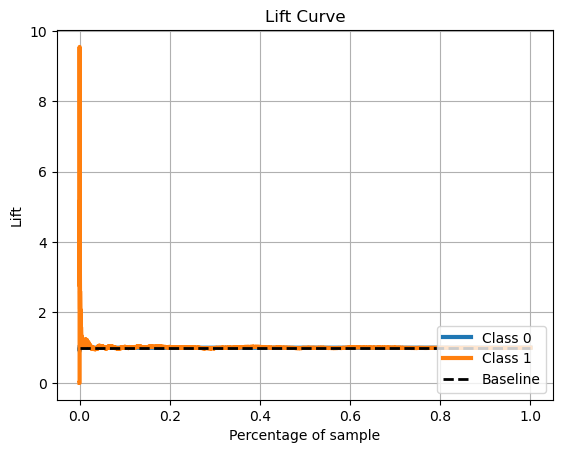

In [15]:
skplt.metrics.plot_lift_curve(y_val_sel, pred_proba)
plt.show()

Dado que la curva es una recta horizontal con un valor de "lift" igual a 1 en todo el rango del eje Y, el modelo no está proporcionando ninguna mejora en la identificación de instancias positivas en comparación con un modelo aleatorio.

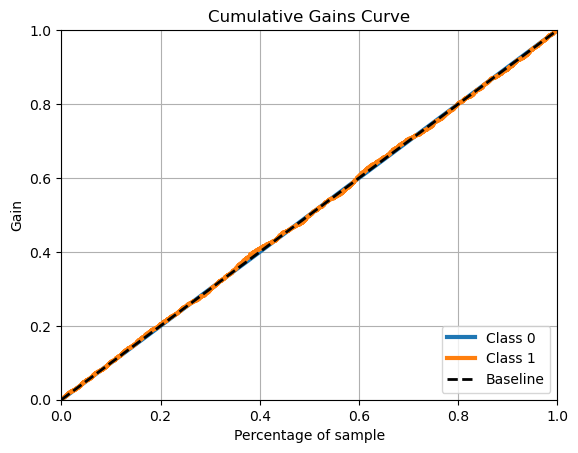

In [16]:
skplt.metrics.plot_cumulative_gain(y_val_sel, pred_proba)
plt.show()

Se observa que la curva de ganancias del modelo base se superpone a la que presentaría un modelo aleatorio y por tanto, el modelo base no mejora la tasa de verdaderos positivos acumulativa más rápidamente de lo que se esperaría al azar.

Se concluye que el modelo base es demasiado simple, lo cual implica limitaciones que se reflejan en métricas poco favorables. En consecuencia, es necesario aplicar otros algoritmos que puedan abordar de manera más efectiva el problema objeto de estudio.

# ÁRBOL DE DECISIÓN

Un árbol de decisión es un modelo predictivo en aprendizaje automático supervisado y no paramétrico que utiliza una estructura de árbol para representar reglas de decisión (empleado tanto clasificación y regresión). Cada nodo interno del árbol representa una prueba sobre una característica del conjunto de datos, las ramas representan los resultados de la prueba, y las hojas indican las predicciones. 

El objetivo es crear un modelo que prediga el valor de una variable objetivo al aprender reglas de decisión simples inferidas a partir de las características de los datos. Estos árboles se construyen dividiendo el conjunto de datos de manera recursiva con el objetivo de maximizar la homogeneidad en términos de la variable objetivo.

Para más información se puede consultar la información que proporciona la web de la librería scikit learn acerca de los árboles de decisión: [Información adicional](https://scikit-learn.org/stable/modules/tree.html)

![imagen](https://images.datacamp.com/image/upload/f_auto,q_auto:best/v1545933328/output_65_0_jteora.png)


A continuación se crea el clasificador del árbol de decisión 'DecisionTreeClassifier' para posteriormente entrenarlo con el conjunto de datos de entrenamiento de reduction: 'X_train_sel_und' e 'y_train_sel_und'.

In [18]:
%%time

clf = DecisionTreeClassifier()

clf= clf.fit(X_train_sel_und,y_train_sel_und)


CPU times: total: 62.5 ms
Wall time: 88 ms


El siguiente paso es visualizar el árbol de decisión entrenado con el clasificador clf mostrándose nodos, ramas y etiquetas de decisión que representan la estructura del árbol.

CPU times: total: 1.19 s
Wall time: 3 s


[Text(0.453114228529411, 0.9833333333333333, 'x[7] <= 0.5\ngini = 0.5\nsamples = 14116\nvalue = [7058, 7058]'),
 Text(0.1838600031544362, 0.95, 'x[10] <= 0.5\ngini = 0.343\nsamples = 5194\nvalue = [1140, 4054]'),
 Text(0.10623461821952378, 0.9166666666666666, 'x[9] <= 0.5\ngini = 0.217\nsamples = 2849\nvalue = [352, 2497]'),
 Text(0.07179387477200609, 0.8833333333333333, 'x[11] <= 0.5\ngini = 0.187\nsamples = 2565\nvalue = [267, 2298]'),
 Text(0.03721610074207331, 0.85, 'x[1] <= 0.757\ngini = 0.133\nsamples = 1668\nvalue = [119, 1549]'),
 Text(0.025897608874896935, 0.8166666666666667, 'x[4] <= 2.5\ngini = 0.104\nsamples = 1320\nvalue = [73, 1247]'),
 Text(0.020813032506308872, 0.7833333333333333, 'x[5] <= 171.5\ngini = 0.099\nsamples = 1306\nvalue = [68, 1238]'),
 Text(0.014541638557829249, 0.75, 'x[2] <= 3.5\ngini = 0.151\nsamples = 402\nvalue = [33, 369]'),
 Text(0.0094945406391325, 0.7166666666666667, 'x[6] <= 0.5\ngini = 0.129\nsamples = 375\nvalue = [26, 349]'),
 Text(0.0046972990

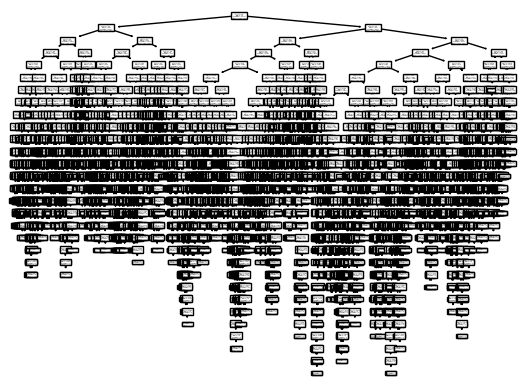

In [19]:
%%time

tree.plot_tree(clf)


En este paso se emplea el clasificador de Árbol de Decisión ('DecisionTreeClassifier') para entrenar un modelo de árbol de decisión. Se entrena el clasificador con el conjunto de datos de características 'X_train_sel_und' y las etiquetas correspondientes 'y_train_sel_und'.

Posteriormente, se utiliza el modelo entrenado para realizar predicciones en el conjunto de validación ('X_val_sel'), almacenándose dichas predicciones en la variable 'y_pred':

In [23]:
tree = DecisionTreeClassifier().fit(X_train_sel_und,y_train_sel_und)
y_pred = tree.predict(X_val_sel)

Por último, se guarda con el módulo pickle el modelo de árbol de decisión entrenado en un archivo llamado 'modelo_decision_tree_sel.pkl'

In [24]:
with open('modelo_decision_tree_sel.pkl', 'wb') as file:
    pickle.dump(tree, file)

# BAYES

Los métodos Naive Bayes son algoritmos de aprendizaje supervisado basados en el teorema de Bayes, con la suposición de independencia condicional entre cada par de características dadas las clases y utilizan el teorema para predecir la probabilidad de una clase dada un conjunto de características. Se utilizan para actualizar las creencias sobre los parámetros del modelo a medida que se observan nuevos datos. Esto es especialmente útil cuando se tiene poca información y se desea incorporar conocimiento previo en el modelo. [Información adicional](https://scikit-learn.org/stable/modules/naive_bayes.html)


![imagen](https://iq.opengenus.org/content/images/2020/02/Screenshot_1.jpg)

En este caso se ha empleado "GaussianNB" que implementa el algoritmo Naive Bayes Gaussiano para clasificación asumiendo que la probabilidad de las características sigue una distribución Gaussiana.

In [25]:
%%time

naive_bayes_model = GaussianNB()

CPU times: total: 0 ns
Wall time: 0 ns


Primero se realiza el ajuste del modelo con los datos de entrenamiento de 'X_train_sel_und', 'y_train_sel_und'. En segundo lugar, se realizan las predicciones en los datos de validación de 'X_val_sel':

In [26]:
%%time

naive_bayes_model.fit(X_train_sel_und, y_train_sel_und)
y_pred = naive_bayes_model.predict(X_val_sel)

CPU times: total: 46.9 ms
Wall time: 52 ms


Por último, se guarda con el módulo pickle el modelo de Bayes entrenado en un archivo llamado 'modelo_naive_bayes_sel.pkl'

In [27]:
with open('modelo_naive_bayes_sel.pkl', 'wb') as file:
    pickle.dump(naive_bayes_model, file)

# SUPPORT VECTOR MACHINE

Una Support Vector Machine (SVM) es un modelo de aprendizaje automático supervisado utilizado para clasificación, regresión y detección de valores atípicos. Su objetivo principal es encontrar un hiperplano en el espacio de características que maximice la separación entre instancias de diferentes clases. SVM se utiliza en una variedad de aplicaciones y es especialmente útil cuando se busca un límite de decisión claro entre clases en conjuntos de datos.
[Información adicional](https://scikit-learn.org/stable/modules/svm.html)


![Imagen](https://datatron.com/wp-content/uploads/2021/05/Support-Vector-Machine.png)

Debido al alto coste computacional de este modelo y después de intentar ejecutarlo en la totalidad del conjunto de datos sin éxito decidimos que únicamente se va a emplear un 15% de 'X_train_sel_und' para este algoritmo. El modelo requeriría de demasiado tiempo de ejecución si se empleara la totalidad del x de entrenamiento, y además, al únicamente emplear un porcentaje reducido del entrenamiento no podemos extrapolar el resultado para el conjunto de datos y por tanto, no podremos seleccionar como modelo ganador a SVM en nuestro proyecto.

Se utiliza SVC que es la clase que implementa Support Vector Classification en Scikit-learn para clasificación:

In [28]:
%%time

percentage_to_use = 0.15
subset_size = int(len(X_train_sel_und) * percentage_to_use)

svm_classifier = SVC()

CPU times: total: 0 ns
Wall time: 0 ns


Primero, se realiza el entrenamiento del modelo con 'X_train_sel_und' e 'y_train_sel_und'; en segundo lugar, se realizan las predicciones sobre el conjunto de validación de 'y_val_red':

In [29]:
%%time

svm_classifier.fit(X_train_sel_und, y_train_sel_und)

predictions_svm = svm_classifier.predict(X_val_sel)

CPU times: total: 36.2 s
Wall time: 1min 29s


Por último, se guarda con el módulo pickle el modelo de SVM entrenado en un archivo llamado 'svm_model_sel.pkl'

In [30]:
with open('svm_model_sel.pkl', 'wb') as model_file:
    pickle.dump(svm_classifier, model_file)

# BAGGING

En el bagging, se selecciona de manera aleatoria una muestra de datos del conjunto de entrenamiento con reemplazo, lo que implica que los puntos de datos individuales pueden ser elegidos más de una vez. Después de generar múltiples muestras de datos, se entrenan modelos débiles de forma independiente. Dependiendo del tipo de tarea, ya sea regresión o clasificación, se obtiene una estimación más precisa al promediar o tomar la mayoría de las predicciones generadas por estos modelos. 
[Información adicional](https://www.ibm.com/es-es/topics/bagging)

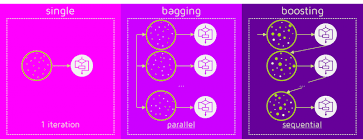


## 1.Random Forest


Un Random Forest es un algoritmo de aprendizaje automático que forma parte de la categoría de métodos de conjunto (ensemble methods). En lugar de depender de un solo modelo, construye múltiples modelos de árboles de decisión durante el entrenamiento a partir de una muestra obtenida con reemplazo (es decir, una muestra bagging) y los combina para obtener una predicción más robusta y precisa.
[Información adicional](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

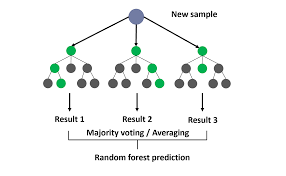

Se utiliza el clasificador 'RandomForestClassifier' para entrenar el modelo con el conjunto de entrenamiento 'X_train_sel_und' e 'y_train_sel_und', y luego se realizan predicciones en el conjunto de validación 'X_val_sel'.

In [31]:
%%time

random_forest = RandomForestClassifier()

random_forest.fit(X_train_sel_und, y_train_sel_und)

predictions_rf = random_forest.predict(X_val_sel)

CPU times: total: 1.5 s
Wall time: 4.15 s


A continuación, generamos una matriz de confusión para el Random Forest:

In [33]:
conf_matrix = confusion_matrix(y_val_sel, predictions_rf)
conf_matrix

array([[124693,  33542],
       [   400,   1365]], dtype=int64)

Por último, se guarda con el módulo pickle el modelo de Random Forest entrenado en un archivo llamado 'random_forest_model_sel.pkl'

In [34]:
with open('random_forest_model_sel.pkl', 'wb') as model_file:
    pickle.dump(random_forest, model_file)

## 2.BaggingClassifier

El Bagging Classifier, o Bootstrap Aggregating Classifier, es un algoritmo de ensamblado que combina múltiples modelos de aprendizaje para mejorar la precisión y robustez del modelo final. La idea principal detrás del bagging es entrenar varios modelos independientes, cada uno en un subconjunto diferente de los datos de entrenamiento, y luego combinar sus predicciones.

El Bagging ayuda a reducir la varianza y mejorar la generalización del modelo al reducir el riesgo de sobreajuste.

[Información adicional](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

A continuación se explican los pasos llevados a cabo en la implementación de un modelo de ensamblado utilizando la técnica de Bagging con un clasificador de árbol de decisión como 'base_model'. 

En primer lugar se crea el modelo base ('base_model') utilizando el clasificador de árbol de decisiones 'DecisionTreeClassifier()'. 

En segundo lugar, se crea un modelo de ensamblado utilizando 'BaggingClassifier' ('bagged_model') entrenando múltiples instancias del mismo modelo base en subconjuntos aleatorios del conjunto de datos de entrenamiento.

En tercer lugar, se entrena el modelo ensamblado utilizando los datos de entrenamiento ('X_train_sel_und' e 'y_train_sel_und').

Por último, una vez que el modelo ensamblado ha sido entrenado, se utiliza para hacer predicciones en un conjunto de datos de validación ('X_val_sel').

In [35]:
base_model = DecisionTreeClassifier()

bagged_model = BaggingClassifier(base_model)

bagged_model.fit(X_train_sel_und, y_train_sel_und)

predictions = bagged_model.predict(X_val_sel)

Por último, se guarda con el módulo pickle el modelo de BaggingClassifier entrenado en un archivo llamado 'bagged_model_sel.pkl'

In [36]:
with open('bagged_model_sel.pkl', 'wb') as model_file:
    pickle.dump(bagged_model, model_file)

# BOOSTING

El boosting es un método de aprendizaje por conjuntos que combina varios modelos de aprendizaje débiles para crear un modelo fuerte que minimiza los errores de entrenamiento. En el boosting, se selecciona una muestra aleatoria de datos, se ajusta un modelo y luego se entrena de manera secuencial. Cada modelo se construye para corregir las debilidades del modelo anterior. En cada iteración, las reglas débiles de cada modelo individual se combinan para formar una regla de predicción más fuerte y precisa. Este enfoque secuencial mejora gradualmente la capacidad del modelo para generalizar y hacer predicciones más precisas.

[Información adicional](https://www.ibm.com/es-es/topics/boosting)

# XGBoost


XGBoost es una biblioteca de aprendizaje automático de código abierto diseñada para implementar algoritmos de gradient boosting. Utiliza el enfoque de construir modelos predictivos combinando varios modelos débiles de manera secuencial, como árboles de decisión. XGBoost incluye características como regularización para prevenir el sobreajuste, manejo eficiente de características para conjuntos de datos grandes, optimización del rendimiento para acelerar el entrenamiento y flexibilidad para adaptarse a diversos problemas.

[Información adicional](https://xgboost.readthedocs.io/en/stable/)

![Foto](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/XGBoost-vs-LightGBM-tree-growth.png?ssl=1)

ESe va a emplear el clasificador 'XGBClassifier' para posteriormente, ajustar el modelo a los datos de entrenamiento 'X_train_sel_und' e 'y_train_sel_und' y realizar predicciones en el conjunto de validación 'X_val_sel':

In [37]:
%%time

xgb_classifier = XGBClassifier()

xgb_classifier.fit(X_train_sel_und, y_train_sel_und)

predictions_xgb = xgb_classifier.predict(X_val_sel)

CPU times: total: 2.34 s
Wall time: 190 ms


Por último, se guarda con el módulo pickle el modelo de XGBoost entrenado en un archivo llamado 'xgb_classifier_model_sel.pkl'

In [38]:
with open('xgb_classifier_model_sel.pkl', 'wb') as model_file:
    pickle.dump(xgb_classifier, model_file)

# AdaBoosting

AdaBoost, o Adaptive Boosting, es un algoritmo de ensamblado que combina varios modelos más débiles, generalmente árboles de decisión poco profundos, para formar un modelo fuerte. Se destaca por su capacidad para adaptarse a los errores del modelo anterior asignando pesos a las instancias del conjunto de entrenamiento, centrándose en mejorar la clasificación de las instancias mal clasificadas. A lo largo de las iteraciones, los modelos más precisos reciben más peso, y la clasificación final se realiza mediante una votación ponderada de los modelos débiles. AdaBoost es robusto, eficaz en problemas de clasificación y puede adaptarse a datos ruidosos. Es una técnica popular en el aprendizaje automático.

[Información adicional](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

Se utiliza el clasificador 'AdaBoostClassifier' para entrenar el modelo con los datos de entrenamiento ('X_train_sel_und' e 'y_train_sel_und') y se realizan predicciones en el conjunto de validación ('X_val_sel').

In [39]:
%%time

adaboost_model = AdaBoostClassifier()

adaboost_model.fit(X_train_sel_und, y_train_sel_und)

predictions_ada = adaboost_model.predict(X_val_sel)

CPU times: total: 453 ms
Wall time: 1.21 s


Por último, se guarda con el módulo pickle el modelo de XGBoost entrenado en un archivo llamado 'adaboost_model_sel.pkl'

In [40]:
with open('adaboost_model_sel.pkl', 'wb') as model_file:
    pickle.dump(adaboost_model, model_file)

# LightGBM

LightGBM es una biblioteca de aprendizaje automático de código abierto  que se especializa en la implementación eficiente de modelos de gradient boosting. Está diseñada para ser rápida y escalable, lo que la hace especialmente útil para conjuntos de datos grandes y complejos.

[Información adicional](https://lightgbm.readthedocs.io/en/stable/)

![Imagen](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/XGBoost-vs-LightGBM-tree-growth-2.png?ssl=1)

Una diferencia entre XGBoost y LightGBM es que mientras XGBoost utiliza algoritmos basados en la clasificación previa, LightGBM usa algoritmos basados en histogramas (es decir, que agrupa los valores de atributos continuos en bins discretos) para agilizar el entrenamiento y reducir el uso de memoria. Otra diferencia es el manejo de las características categóricas: XGBoost trata por defecto las variables categóricas como numéricas ordenadas, requiriendo codificación one-hot para evitar problemas de interpretación mientras que LightGBM maneja características categóricas fácilmente, permitiendo la especificación de columnas categóricas y dividiendo por igualdad.

[Información adicional](https://dev.to/ruizleandro/introduccion-a-lightgbm-ij7#:~:text=A%20diferencia%20de%20XGBoost%20(entre,reducir%20el%20uso%20de%20memoria.)

[Más información acerca de las diferencias](https://neptune.ai/blog/xgboost-vs-lightgbm)

Se va a emplear el clasificador 'LGBMClassifier' para posteriormente, ajustar el modelo a los datos de entrenamiento 'X_train_sel_und' e 'y_train_sel_und' y realizar predicciones en el conjunto de validación 'X_val_sel':

In [41]:
%%time

lgb_classifier = LGBMClassifier()

lgb_classifier.fit(X_train_sel_und, y_train_sel_und)

predictions_lgb = lgb_classifier.predict(X_val_sel)

[LightGBM] [Info] Number of positive: 7058, number of negative: 7058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 14116, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 1.83 s
Wall time: 352 ms


Por último, se guarda con el módulo pickle el modelo de LightGBM entrenado en un archivo llamado 'lgb_model_sel.pkl'

In [42]:
with open('lgb_model_sel.pkl', 'wb') as model_file:
    pickle.dump(lgb_classifier, model_file)

## Anteriores resultados con PIPELINE 

Este pipeline encapsula los modelos empleados a lo largo de este notebook, automatizando la comparación de varios su comparación y proporciona métricas de rendimiento para cada modelo en el conjunto de validación (accuracy, la precisión, el recall y F1 score):

In [43]:
%%time

classifiers = [
    DecisionTreeClassifier(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier(),
    BaggingClassifier(base_model),
    XGBClassifier(),
    AdaBoostClassifier(),
    LGBMClassifier(),
]

results = {}

for classifier in tqdm(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_sel_und, y_train_sel_und)  
    
    predictions = pipe.predict(X_val_sel)

    if hasattr(classifier, "predict_proba"):
        probabilities = pipe.predict_proba(X_val_sel)[:, 1]
        roc_auc = roc_auc_score(y_val_sel, probabilities)
    else:
        roc_auc = "N/A"

    accuracy = accuracy_score(y_val_sel, predictions)
    class_report = classification_report(y_val_sel, predictions)
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_val_sel, predictions)

    print(f"\n{classifier}")
    print(f"ROC-AUC score of the model: {roc_auc}")
    print(f"Accuracy of the model: {accuracy:.5f}")
    print("Classification report: ")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Guardando el modelo y las métricas en un archivo pickle
    results[classifier] = {
        'model': pipe,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'class_report': class_report,
        'confusion_matrix': conf_matrix
    }


# Guardar todos los resultados en un archivo pickle
#with open('../models/model_results.pickle', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


 12%|█▎        | 1/8 [00:00<00:02,  3.03it/s]


DecisionTreeClassifier()
ROC-AUC score of the model: 0.7005906784571411
Accuracy of the model: 0.69868
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    158235
           1       0.03      0.70      0.05      1765

    accuracy                           0.70    160000
   macro avg       0.51      0.70      0.43    160000
weighted avg       0.98      0.70      0.81    160000

Confusion Matrix:
[[110548  47687]
 [   525   1240]]


 25%|██▌       | 2/8 [00:00<00:01,  3.15it/s]


GaussianNB()
ROC-AUC score of the model: 0.8183795948060542
Accuracy of the model: 0.68953
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.69      0.81    158235
           1       0.03      0.79      0.05      1765

    accuracy                           0.69    160000
   macro avg       0.51      0.74      0.43    160000
weighted avg       0.99      0.69      0.81    160000

Confusion Matrix:
[[108926  49309]
 [   366   1399]]


 38%|███▊      | 3/8 [01:29<03:23, 40.74s/it]


SVC()
ROC-AUC score of the model: N/A
Accuracy of the model: 0.71282
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.71      0.83    158235
           1       0.03      0.68      0.05      1765

    accuracy                           0.71    160000
   macro avg       0.51      0.70      0.44    160000
weighted avg       0.98      0.71      0.82    160000

Confusion Matrix:
[[112846  45389]
 [   560   1205]]


 50%|█████     | 4/8 [01:36<01:48, 27.24s/it]


RandomForestClassifier()
ROC-AUC score of the model: 0.8571004291229265
Accuracy of the model: 0.78742
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    158235
           1       0.04      0.77      0.07      1765

    accuracy                           0.79    160000
   macro avg       0.52      0.78      0.48    160000
weighted avg       0.99      0.79      0.87    160000

Confusion Matrix:
[[124620  33615]
 [   398   1367]]


 62%|██████▎   | 5/8 [01:37<00:53, 17.91s/it]


BaggingClassifier(estimator=DecisionTreeClassifier())
ROC-AUC score of the model: 0.8284070157422652
Accuracy of the model: 0.78968
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    158235
           1       0.04      0.72      0.07      1765

    accuracy                           0.79    160000
   macro avg       0.52      0.76      0.48    160000
weighted avg       0.99      0.79      0.87    160000

Confusion Matrix:
[[125069  33166]
 [   486   1279]]


 75%|███████▌  | 6/8 [01:37<00:23, 11.97s/it]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
ROC-AUC score of the model: 0.859384175166727
Accuracy of the model: 0.78185
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88    158235
           1       0.04      0.

 88%|████████▊ | 7/8 [01:40<00:08,  8.83s/it]


AdaBoostClassifier()
ROC-AUC score of the model: 0.8751295268422706
Accuracy of the model: 0.80018
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    158235
           1       0.04      0.79      0.08      1765

    accuracy                           0.80    160000
   macro avg       0.52      0.80      0.48    160000
weighted avg       0.99      0.80      0.88    160000

Confusion Matrix:
[[126627  31608]
 [   363   1402]]
[LightGBM] [Info] Number of positive: 7058, number of negative: 7058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 14116, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

100%|██████████| 8/8 [01:40<00:00, 12.60s/it]


LGBMClassifier()
ROC-AUC score of the model: 0.8705806519528321
Accuracy of the model: 0.79024
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    158235
           1       0.04      0.79      0.08      1765

    accuracy                           0.79    160000
   macro avg       0.52      0.79      0.48    160000
weighted avg       0.99      0.79      0.87    160000

Confusion Matrix:
[[125036  33199]
 [   362   1403]]
CPU times: total: 44.5 s
Wall time: 1min 40s


Este notebook (datasets de 'selection') será comparado con el siguiente notebook que contiene a los datasets 'reduced' para ver qué modelos son los que poseen unos mayores valores de F1- score y cuáles son los candidatos a ganadores como modelos para este proyecto.

Se observa en el anterior pipeline que:
- **AdaBoosting es el modelo que presenta mayores valores de f1-score**: 89% y 8% de aciertos para los casos en los que la variables objetivo toma 0 y 1, respectivamente.

- El **siguiente mejor modelo con respecto a esta métrica es LightGBM** con unos valores de f1-score de 88% y 7% para los casos en los que la variables objetivo toma 0 y 1, respectivamente.

- Los modelos que proporcionan los peores resultados de f1-score son el Árbol de decisión y Bayes en los datasets seleccionados.


# CONCLUSIONES

- En este notebook, hemos utilizado los conjuntos de datos 'X_train_sel_und', 'X_val_sel', 'y_train_sel_std_und' e 'y_val_sel' en todos los modelos. Es importante señalar que los **conjuntos de datos estandarizados, 'X_train_sel_std' y 'X_val_sel_std', no se han empleado en este cuaderno**, ya que los **algoritmos** implementados **no se centran en problemas de regresión**.

- Además, cabe destacar que únicamente se han utilizado los **conjuntos de datos balanceados con la técnica del undersampling en el train** (la validación está sin balancear).

- **Los resultados al modelizar estos datasets** (los de las variables seleccionadas por las regularizaciones de Ridge y Lasso ('sel')) tendrán que ser **comparados con los resultados** de los datasets obtenidos de la selección de variables y feature engineering realizadas en anteriores notebooks ('red'), es decir, el **siguiente notebook**

- **El modelo que presenta los mayores f1-score de los datasets 'selected' es AdaBoosting** con un 89% y 8% de aciertos para los casos en los que la variables objetivo toma 0 y 1, respectivamente. Siendo el segundo mejor modelo en relación con estas métricas LightGBM que presenta unos valores bastante similares al anterior modelo (89% y 7%, respectivamente).